In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

ds = tfds.load('mnist', download=True, split='train', shuffle_files=True)
# ds = ds.shuffle(1024).repeat().batch(32).prefetch(1).take(100000)
ds = ds.map(lambda sample: {
    'image': tf.cast(sample['image'], tf.float32) / 255.,
    'label': sample['label']})
ds = ds.repeat(100).shuffle(1024).batch(32).prefetch(1).take(1000)

# ds

2024-03-22 15:00:25.213108: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-22 15:00:25.974124: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-03-22 15:00:28.179081: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [2]:
for d in ds.as_numpy_iterator():
    print(d.keys(), d['image'].shape, d['label'].shape)
    break

dict_keys(['image', 'label']) (32, 28, 28, 1) (32,)


2024-03-22 15:00:28.355471: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


# No BatchNorm

In [3]:
import jax
import jax.numpy as jnp
import flax
import flax.linen as nn
import numpy as np

In [4]:
class MLP(nn.Module):
    @nn.compact
    def __call__(self, x):
        # x = x.reshape((1, -1))
        x = nn.Dense(features=32)(x)
        x = nn.relu(x)
        x = nn.Dense(features=64)(x)
        x = nn.relu(x)
        x = nn.Dense(features=128)(x)
        x = nn.relu(x)
        x = nn.Dense(features=256)(x)
        x = nn.relu(x)
        x = x.reshape((x.shape[0], -1))
        x = nn.Dense(features=10)(x)
        return x

When creating a model, initialize it by calling `nn.init()` to get the `variables` structure. \
The difference between the code without and with `BatchNorm` is that the `train` argument must be provided.

In [5]:
mlp = MLP()
x = jnp.ones((1, 28, 28, 1))
variables = mlp.init(jax.random.PRNGKey(0), x)
params = variables['params']

from pprint import pprint
pprint(jax.tree_util.tree_map(jnp.shape, variables))

{'params': {'Dense_0': {'bias': (32,), 'kernel': (1, 32)},
            'Dense_1': {'bias': (64,), 'kernel': (32, 64)},
            'Dense_2': {'bias': (128,), 'kernel': (64, 128)},
            'Dense_3': {'bias': (256,), 'kernel': (128, 256)},
            'Dense_4': {'bias': (10,), 'kernel': (200704, 10)}}}


In [6]:
y = mlp.apply(
    {'params': params},
    x,
)
y.shape

(1, 10)

In [7]:
# Train & evaluate; create initial state
from flax.training import train_state
from flax.training.train_state import TrainState
import optax

state = train_state.TrainState.create(
    apply_fn=mlp.apply,
    params=params,
    tx=optax.adam(1e-3)
)

# pprint(state)

In [8]:
# pprint(state.params)

In [9]:
# Train & evaluate; define train step
@jax.jit
def train_step(state: TrainState, batch):
    def loss_fn(params):
        logits = state.apply_fn(
            {'params': params},
            x=batch['image']
        )
        loss = jnp.sum(optax.softmax_cross_entropy_with_integer_labels(
            logits=logits, labels=batch['label']
        ))
        return loss, logits
    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)

    (loss, logits), grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)

    metrics = {
        'loss': loss,
        'accuracy': jnp.mean(jnp.argmax(logits, -1) == batch['label'])
    }
    return state, metrics


from tqdm import tqdm

history = []
total_steps = ds.cardinality().numpy()
for batch in tqdm(ds.as_numpy_iterator(), total=total_steps):
    state, logs = train_step(state, batch)
    print("1//", logs, type(logs))
    logs = jax.tree_map(np.asarray, logs)
    print("2//", logs, type(logs))
    
    history.append(logs)
    

  6%|▌         | 62/1000 [00:00<00:09, 100.52it/s]

1// {'accuracy': Array(0.03125, dtype=float32), 'loss': Array(73.693695, dtype=float32)} <class 'dict'>
2// {'accuracy': array(0.03125, dtype=float32), 'loss': array(73.693695, dtype=float32)} <class 'dict'>
1// {'accuracy': Array(0.25, dtype=float32), 'loss': Array(69.413635, dtype=float32)} <class 'dict'>
2// {'accuracy': array(0.25, dtype=float32), 'loss': array(69.413635, dtype=float32)} <class 'dict'>
1// {'accuracy': Array(0.59375, dtype=float32), 'loss': Array(49.177967, dtype=float32)} <class 'dict'>
2// {'accuracy': array(0.59375, dtype=float32), 'loss': array(49.177967, dtype=float32)} <class 'dict'>
1// {'accuracy': Array(0.46875, dtype=float32), 'loss': Array(47.00116, dtype=float32)} <class 'dict'>
2// {'accuracy': array(0.46875, dtype=float32), 'loss': array(47.00116, dtype=float32)} <class 'dict'>
1// {'accuracy': Array(0.625, dtype=float32), 'loss': Array(32.955887, dtype=float32)} <class 'dict'>
2// {'accuracy': array(0.625, dtype=float32), 'loss': array(32.955887, dty

 26%|██▌       | 256/1000 [00:01<00:01, 380.75it/s]

{'accuracy': Array(0.90625, dtype=float32), 'loss': Array(15.555714, dtype=float32)} <class 'dict'>
2// {'accuracy': array(0.90625, dtype=float32), 'loss': array(15.555714, dtype=float32)} <class 'dict'>
1// {'accuracy': Array(0.875, dtype=float32), 'loss': Array(12.92692, dtype=float32)} <class 'dict'>
2// {'accuracy': array(0.875, dtype=float32), 'loss': array(12.92692, dtype=float32)} <class 'dict'>
1// {'accuracy': Array(0.90625, dtype=float32), 'loss': Array(12.270226, dtype=float32)} <class 'dict'>
2// {'accuracy': array(0.90625, dtype=float32), 'loss': array(12.270226, dtype=float32)} <class 'dict'>
1// {'accuracy': Array(0.875, dtype=float32), 'loss': Array(17.678875, dtype=float32)} <class 'dict'>
2// {'accuracy': array(0.875, dtype=float32), 'loss': array(17.678875, dtype=float32)} <class 'dict'>
1// {'accuracy': Array(0.90625, dtype=float32), 'loss': Array(11.649735, dtype=float32)} <class 'dict'>
2// {'accuracy': array(0.90625, dtype=float32), 'loss': array(11.649735, dtype

 39%|███▉      | 393/1000 [00:01<00:01, 514.43it/s]

1// {'accuracy': Array(0.90625, dtype=float32), 'loss': Array(10.659292, dtype=float32)} <class 'dict'>
2// {'accuracy': array(0.90625, dtype=float32), 'loss': array(10.659292, dtype=float32)} <class 'dict'>
1// {'accuracy': Array(0.8125, dtype=float32), 'loss': Array(27.904884, dtype=float32)} <class 'dict'>
2// {'accuracy': array(0.8125, dtype=float32), 'loss': array(27.904884, dtype=float32)} <class 'dict'>
1// {'accuracy': Array(0.84375, dtype=float32), 'loss': Array(26.414389, dtype=float32)} <class 'dict'>
2// {'accuracy': array(0.84375, dtype=float32), 'loss': array(26.414389, dtype=float32)} <class 'dict'>
1// {'accuracy': Array(0.875, dtype=float32), 'loss': Array(22.10168, dtype=float32)} <class 'dict'>
2// {'accuracy': array(0.875, dtype=float32), 'loss': array(22.10168, dtype=float32)} <class 'dict'>
1// {'accuracy': Array(0.875, dtype=float32), 'loss': Array(11.182439, dtype=float32)} <class 'dict'>
2// {'accuracy': array(0.875, dtype=float32), 'loss': array(11.182439, dty

 53%|█████▎    | 532/1000 [00:01<00:00, 598.54it/s]

1// {'accuracy': Array(0.90625, dtype=float32), 'loss': Array(14.825483, dtype=float32)} <class 'dict'>
2// {'accuracy': array(0.90625, dtype=float32), 'loss': array(14.825483, dtype=float32)} <class 'dict'>
1// {'accuracy': Array(1., dtype=float32), 'loss': Array(3.0202847, dtype=float32)} <class 'dict'>
2// {'accuracy': array(1., dtype=float32), 'loss': array(3.0202847, dtype=float32)} <class 'dict'>
1// {'accuracy': Array(0.8125, dtype=float32), 'loss': Array(16.640715, dtype=float32)} <class 'dict'>
2// {'accuracy': array(0.8125, dtype=float32), 'loss': array(16.640715, dtype=float32)} <class 'dict'>
1// {'accuracy': Array(0.8125, dtype=float32), 'loss': Array(13.683645, dtype=float32)} <class 'dict'>
2// {'accuracy': array(0.8125, dtype=float32), 'loss': array(13.683645, dtype=float32)} <class 'dict'>
1// {'accuracy': Array(0.96875, dtype=float32), 'loss': Array(7.1344824, dtype=float32)} <class 'dict'>
2// {'accuracy': array(0.96875, dtype=float32), 'loss': array(7.1344824, dtype

 67%|██████▋   | 672/1000 [00:01<00:00, 645.94it/s]

1// {'accuracy': Array(0.78125, dtype=float32), 'loss': Array(20.956585, dtype=float32)} <class 'dict'>
2// {'accuracy': array(0.78125, dtype=float32), 'loss': array(20.956585, dtype=float32)} <class 'dict'>
1// {'accuracy': Array(0.90625, dtype=float32), 'loss': Array(12.419117, dtype=float32)} <class 'dict'>
2// {'accuracy': array(0.90625, dtype=float32), 'loss': array(12.419117, dtype=float32)} <class 'dict'>
1// {'accuracy': Array(0.9375, dtype=float32), 'loss': Array(7.685753, dtype=float32)} <class 'dict'>
2// {'accuracy': array(0.9375, dtype=float32), 'loss': array(7.685753, dtype=float32)} <class 'dict'>
1// {'accuracy': Array(0.90625, dtype=float32), 'loss': Array(5.6914334, dtype=float32)} <class 'dict'>
2// {'accuracy': array(0.90625, dtype=float32), 'loss': array(5.6914334, dtype=float32)} <class 'dict'>
1// {'accuracy': Array(0.875, dtype=float32), 'loss': Array(22.5564, dtype=float32)} <class 'dict'>
2// {'accuracy': array(0.875, dtype=float32), 'loss': array(22.5564, dty

 74%|███████▍  | 742/1000 [00:01<00:00, 659.21it/s]

1// {'accuracy': Array(0.90625, dtype=float32), 'loss': Array(9.549437, dtype=float32)} <class 'dict'>
2// {'accuracy': array(0.90625, dtype=float32), 'loss': array(9.549437, dtype=float32)} <class 'dict'>
1// {'accuracy': Array(0.9375, dtype=float32), 'loss': Array(10.102885, dtype=float32)} <class 'dict'>
2// {'accuracy': array(0.9375, dtype=float32), 'loss': array(10.102885, dtype=float32)} <class 'dict'>
1// {'accuracy': Array(0.90625, dtype=float32), 'loss': Array(23.857746, dtype=float32)} <class 'dict'>
2// {'accuracy': array(0.90625, dtype=float32), 'loss': array(23.857746, dtype=float32)} <class 'dict'>
1// {'accuracy': Array(1., dtype=float32), 'loss': Array(2.3812943, dtype=float32)} <class 'dict'>
2// {'accuracy': array(1., dtype=float32), 'loss': array(2.3812943, dtype=float32)} <class 'dict'>
1// {'accuracy': Array(0.9375, dtype=float32), 'loss': Array(9.930198, dtype=float32)} <class 'dict'>
2// {'accuracy': array(0.9375, dtype=float32), 'loss': array(9.930198, dtype=flo

 88%|████████▊ | 882/1000 [00:02<00:00, 676.12it/s]

1// {'accuracy': Array(0.90625, dtype=float32), 'loss': Array(9.691168, dtype=float32)} <class 'dict'>
2// {'accuracy': array(0.90625, dtype=float32), 'loss': array(9.691168, dtype=float32)} <class 'dict'>
1// {'accuracy': Array(0.875, dtype=float32), 'loss': Array(10.254286, dtype=float32)} <class 'dict'>
2// {'accuracy': array(0.875, dtype=float32), 'loss': array(10.254286, dtype=float32)} <class 'dict'>
1// {'accuracy': Array(0.96875, dtype=float32), 'loss': Array(3.3769836, dtype=float32)} <class 'dict'>
2// {'accuracy': array(0.96875, dtype=float32), 'loss': array(3.3769836, dtype=float32)} <class 'dict'>
1// {'accuracy': Array(0.9375, dtype=float32), 'loss': Array(12.3247175, dtype=float32)} <class 'dict'>
2// {'accuracy': array(0.9375, dtype=float32), 'loss': array(12.3247175, dtype=float32)} <class 'dict'>
1// {'accuracy': Array(0.90625, dtype=float32), 'loss': Array(13.471846, dtype=float32)} <class 'dict'>
2// {'accuracy': array(0.90625, dtype=float32), 'loss': array(13.47184

100%|██████████| 1000/1000 [00:02<00:00, 447.34it/s]


1// {'accuracy': Array(0.9375, dtype=float32), 'loss': Array(8.008193, dtype=float32)} <class 'dict'>
2// {'accuracy': array(0.9375, dtype=float32), 'loss': array(8.008193, dtype=float32)} <class 'dict'>
1// {'accuracy': Array(0.90625, dtype=float32), 'loss': Array(11.83955, dtype=float32)} <class 'dict'>
2// {'accuracy': array(0.90625, dtype=float32), 'loss': array(11.83955, dtype=float32)} <class 'dict'>
1// {'accuracy': Array(0.84375, dtype=float32), 'loss': Array(13.62961, dtype=float32)} <class 'dict'>
2// {'accuracy': array(0.84375, dtype=float32), 'loss': array(13.62961, dtype=float32)} <class 'dict'>
1// {'accuracy': Array(0.9375, dtype=float32), 'loss': Array(6.996662, dtype=float32)} <class 'dict'>
2// {'accuracy': array(0.9375, dtype=float32), 'loss': array(6.996662, dtype=float32)} <class 'dict'>
1// {'accuracy': Array(0.84375, dtype=float32), 'loss': Array(24.777662, dtype=float32)} <class 'dict'>
2// {'accuracy': array(0.84375, dtype=float32), 'loss': array(24.777662, dty

In [ ]:
@jax.jit
def eval_step(state: TrainState, batch):
    logits = state.apply_fn(
        {'params': params},
        x=batch['image']
    )
    loss = optax.softmax_cross_entropy_with_integer_labels(
        logits=logits, labels=batch['label']
    )
    metrics = {
        'loss': loss,
        'accuracy': jnp.mean(jnp.argmax(logits, -1) == batch['label'])
    }
    return state, metrics

In [ ]:
# eval_step = jax.pmap(eval_step, axis_name='batch')
# eval_step = flax.jax_utils.pad_shard_unpad(eval_step, static_argnums=(1,), static_return=True)

In [ ]:
list(ds_test.batch(1).as_numpy_iterator())[0]['image'].shape

(1, 32, 28, 28, 1)

In [ ]:
# ds_test = tfds.load('mnist', download=True, split='test', shuffle_files=True)
# ds_test = ds_test.shuffle(2).repeat().prefetch(1).take(1000)

# state = train_state.TrainState.create(
#     apply_fn=mlp.apply,
#     params=params,
#     tx=optax.adam(1e-3)
# )

ds_test = tfds.load('mnist', split='test')
ds_test = ds_test.map(lambda sample: {
    'image': tf.cast(sample['image'], tf.float32) / 255.,
    'label': sample['label']
})
ds_test = ds_test.shuffle(1024).batch(32).prefetch(1).take(100)

history_test = []
total_steps = ds.cardinality().numpy()
state_test = state

for batch in tqdm(ds_test.as_numpy_iterator()):
    # print(batch['image'].shape)
    # state_test, logs_test = eval_step(state_test, batch)
    # logs_test = jax.tree_map(np.asarray, logs_test)
    # history_test.append(logs_test)
    state_test, logs_test = eval_step(state_test, batch)
    logs_test = jax.tree_map(np.asarray, logs_test)
    history_test.append(logs_test)

print(f"\nAcc.: {np.mean([h['accuracy'] for h in history_test]):.3f}")

100it [00:04, 22.03it/s]



Acc.: 0.116


In [ ]:
logs_test

{'accuracy': array(0.09375, dtype=float32),
 'loss': array([2.3001986, 2.26472  , 2.2703178, 2.3030581, 2.3222327, 2.3170176,
        2.2634583, 2.2948074, 2.2187119, 2.2947953, 2.3167071, 2.3012462,
        2.2565858, 2.3204112, 2.3254523, 2.2168036, 2.3917532, 2.2121403,
        2.2092702, 2.2592049, 2.3376474, 2.403379 , 2.267333 , 2.3139195,
        2.268133 , 2.2903469, 2.3540072, 2.234002 , 2.3249311, 2.2733436,
        2.2795732, 2.314519 ], dtype=float32)}

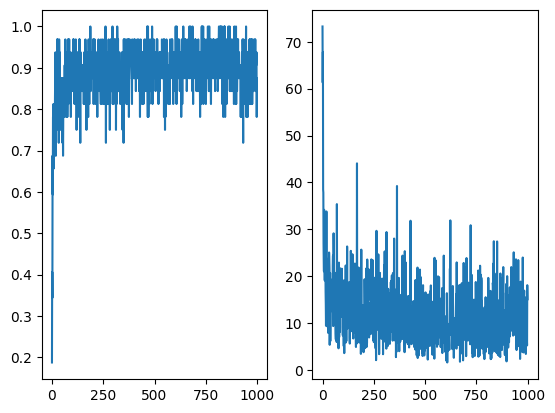

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2)
ax = ax.flatten()
ax[0].plot(range(len(history)), [h['accuracy'].ravel() for h in history])
ax[1].plot(range(len(history)), [h['loss'] for h in history])

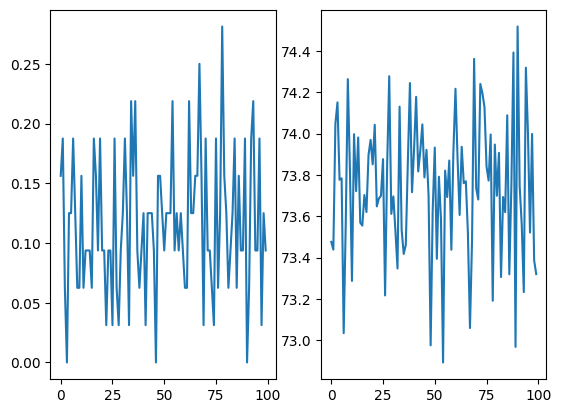

In [ ]:
fig, ax = plt.subplots(1, 2)
ax = ax.flatten()
ax[0].plot(range(len(history_test)), [h['accuracy'].ravel() for h in history_test])
ax[1].plot(range(len(history_test)), [h['loss'].sum() for h in history_test])

이상해요

# Apply BatchNorm

In [2]:
# dataset
import tensorflow as tf
import tensorflow_datasets as tfds

train_ds = tfds.load('mnist', split='train')
test_ds = tfds.load('mnist', split='test')

def data_normalize(ds):
    return ds.map(lambda sample: {
        'image': tf.cast(sample['image'], tf.float32) / 255.,
        'label': sample['label']
    })

num_epochs = 100
batch_size = 32

train_ds = data_normalize(train_ds)
test_ds = data_normalize(test_ds)

train_ds = train_ds.repeat(num_epochs).shuffle(1024).batch(batch_size).prefetch(1)
test_ds = test_ds.shuffle(1024).batch(batch_size).prefetch(1)


In [3]:
# Module w/ batchnorm
import jax
import flax
import flax.linen as nn
import jax.numpy as jnp

class MLP(nn.Module):
    @nn.compact
    def __call__(self, x, train: bool):
        '''If using `nn.BatchNorm`, need to use an argument `train`.'''
        x = nn.Dense(4)(x)
        # print('1: ', x.shape)
        x = nn.BatchNorm(use_running_average=not train)(x)
        x = nn.relu(x)
        x = x.reshape((x.shape[0], -1))
        # print('2: ', x.shape)
        x = nn.Dense(10)(x)
        # print('3: ', x.shape)
        return x

In [10]:
# Initialize
mlp = MLP()
x = jnp.ones((1, 28, 28, 1))
variables = mlp.init(jax.random.PRNGKey(42), x, train=False)
params = variables['params']
batch_stats = variables['batch_stats']

from pprint import pprint
pprint(jax.tree_util.tree_map(jnp.shape, variables))

{'batch_stats': {'BatchNorm_0': {'mean': (4,), 'var': (4,)}},
 'params': {'BatchNorm_0': {'bias': (4,), 'scale': (4,)},
            'Dense_0': {'bias': (4,), 'kernel': (1, 4)},
            'Dense_1': {'bias': (10,), 'kernel': (3136, 10)}}}


In [11]:
# How to use `nn.apply`
#   When given `train==True` (`use_running_average==False`), the model will run.
y, updates = mlp.apply(
    {'params': params, 'batch_stats': batch_stats},
    x,
    train=True, mutable=['batch_stats']
)
batch_stats = updates['batch_stats']

In [12]:
# Train
#   I should re-define class `TrainState` within `batch_stats`.
from flax.training import train_state
from typing import Any
import optax

class TrainState(train_state.TrainState):
    batch_stats: Any

state = TrainState.create(
    apply_fn=mlp.apply,
    params=params,
    batch_stats=batch_stats,
    tx=optax.adam(1e-3),
)

pprint(state.params)

{'BatchNorm_0': {'bias': Array([0., 0., 0., 0.], dtype=float32),
                 'scale': Array([1., 1., 1., 1.], dtype=float32)},
 'Dense_0': {'bias': Array([0., 0., 0., 0.], dtype=float32),
             'kernel': Array([[-1.2169683 ,  0.9322757 ,  0.76504534, -0.75797063]], dtype=float32)},
 'Dense_1': {'bias': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32),
             'kernel': Array([[-0.02029229, -0.01774194,  0.02138496, ..., -0.03516004,
         0.03271092,  0.00258432],
       [-0.02830074, -0.0015541 ,  0.03536616, ..., -0.00421275,
        -0.0261338 ,  0.0094461 ],
       [ 0.01336632, -0.00968186,  0.02290919, ...,  0.00982715,
        -0.01635133, -0.00976977],
       ...,
       [-0.03745922, -0.0197634 ,  0.01113755, ..., -0.0291111 ,
        -0.0166876 ,  0.02659808],
       [ 0.01138273, -0.00866457,  0.00485947, ..., -0.02484313,
         0.02940287, -0.00507673],
       [-0.01494798,  0.0086039 , -0.00300997, ...,  0.00951076,
         0.00806458,

loss는 (batch, classes)=(32, 10)를 띄고 있는데, 이러면 안되고 하나의 scalar값으로 떠야한다.

하나의 batch에서 각 label(10)에 대한 loss는 sum | mean. \
모든 batch에서 앞서 구한 summation loss를 mean.


In [13]:
from functools import partial

@jax.jit
def train_step(state: TrainState, batch):
    '''Train for a single step'''
    @jax.jit
    def loss_fn(params):
        logits, updates = state.apply_fn(
            {'params': params, 'batch_stats': state.batch_stats},
            x=batch['image'], train=True, mutable=['batch_stats']
        )
        # pprint(logits.shape)
        # pprint(type(updates))
        loss = optax.softmax_cross_entropy_with_integer_labels(
            logits=logits, labels=batch['label']
        ).mean()        # cross entropy loss는 scalar값이여지 ㅋㅋ ㄹㅇ. 이거 때매 며칠걸린거임???
        return loss, (logits, updates)

    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (loss, (logits, updates)), grads = grad_fn(state.params)

    state = state.apply_gradients(grads=grads)
    state = state.replace(batch_stats=updates['batch_stats'])
    metrics = {
        'loss': loss,
        'accuracy': jnp.mean(jnp.argmax(logits, -1) == batch['label']),
    }
    return state, metrics

In [14]:
@jax.jit
def eval_step(state: TrainState, batch):
    '''Single step'''
    logits = state.apply_fn(
        {'params': params, 'batch_stats': state.batch_stats},
        x=batch['image'], train=False
    )
    loss = optax.softmax_cross_entropy_with_integer_labels(
        logits=logits, labels=batch['label']
    ).mean()
    metrics = {
        'loss': loss,
        'accuracy': jnp.mean(jnp.argmax(logits, -1) == batch['label'])
    }
    return state, metrics

In [15]:
from tqdm import tqdm
import numpy as np

total_steps = train_ds.cardinality().numpy()
history = []

for epoch in range(num_epochs):
    history_epoch = []
    for batch in tqdm(train_ds.as_numpy_iterator(), total=total_steps):
        # print(batch['image'].shape, batch['label'])
        state, logs = train_step(state, batch)
        logs = jax.tree_map(np.asarray, logs)
        history_epoch.append(logs)
    hd = {'accuracy': [], 'loss': []}
    hd['accuracy'].append(np.mean([he['accuracy'] for he in history_epoch]))    # 모든 batch에 대해 mean
    hd['loss'].append(np.sum([he['loss'] for he in history_epoch]))
    history.append(hd)

  5%|▍         | 8441/187500 [00:42<14:57, 199.54it/s]


KeyboardInterrupt: 

In [16]:
history

[{'accuracy': [0.94919515], 'loss': [32977.918]}]

In [19]:
history_test = []
total_steps = test_ds.cardinality().numpy()

for batch in tqdm(test_ds.as_numpy_iterator(), total=total_steps):
    state, logs = eval_step(state, batch)
    logs = jax.tree_map(np.asarray, logs)
    history_test.append(logs)

100%|██████████| 313/313 [00:03<00:00, 93.09it/s] 


In [20]:
history_test

[{'accuracy': array(0.125, dtype=float32),
  'loss': array(7.945651, dtype=float32)},
 {'accuracy': array(0.09375, dtype=float32),
  'loss': array(7.5593367, dtype=float32)},
 {'accuracy': array(0.125, dtype=float32),
  'loss': array(8.136024, dtype=float32)},
 {'accuracy': array(0.09375, dtype=float32),
  'loss': array(7.8638935, dtype=float32)},
 {'accuracy': array(0.125, dtype=float32),
  'loss': array(8.460057, dtype=float32)},
 {'accuracy': array(0.0625, dtype=float32),
  'loss': array(8.65219, dtype=float32)},
 {'accuracy': array(0.09375, dtype=float32),
  'loss': array(8.939895, dtype=float32)},
 {'accuracy': array(0.09375, dtype=float32),
  'loss': array(8.464176, dtype=float32)},
 {'accuracy': array(0.09375, dtype=float32),
  'loss': array(9.120495, dtype=float32)},
 {'accuracy': array(0.03125, dtype=float32),
  'loss': array(8.506047, dtype=float32)},
 {'accuracy': array(0.28125, dtype=float32),
  'loss': array(6.073853, dtype=float32)},
 {'accuracy': array(0.125, dtype=float

# Parallel Learning w/ BatchNorm

* NOTICE) Must restart this session, and run below cell first if you use CPU.

In [2]:
import os
# os.environ['XLA_FLAGS'] = '--xla_force_host_platform_device_count=4'
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1,2,4'      # 3 is just GPU for display.

In [3]:
import jax
jax.devices()

[gpu(id=0), gpu(id=1), gpu(id=2), gpu(id=3)]

In [4]:
# Settings
import numpy as np

import jax
from jax import lax, random, numpy as jnp

import flax
from flax import struct, traverse_util, linen as nn
from flax.core import freeze, unfreeze
from flax.training import train_state, checkpoints

import optax

from functools import partial
from typing import Optional, Callable, Any

2024-03-07 17:09:21.947360: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [5]:
# Dataset loading
import tensorflow_datasets as tfds
import tensorflow as tf

num_epochs = 10
batch_size = 32


train_ds = tfds.load('mnist', split='train')
test_ds = tfds.load('mnist', split='test')

def data_normalize(ds):
    return ds.map(lambda sample: {
        'image': tf.cast(sample['image'], tf.float32) / 255.,
        'label': sample['label']
    })


train_ds = data_normalize(train_ds)
test_ds = data_normalize(test_ds)

train_ds = train_ds.repeat(num_epochs).shuffle(1024).batch(batch_size).prefetch(1)
test_ds = test_ds.shuffle(1024).batch(batch_size).prefetch(1)



/home/nvidia/anaconda3/envs/jaxrunner/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-03-07 17:09:23.614414: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [6]:
# Sharding
from jax.sharding import Mesh, PartitionSpec, NamedSharding
from jax.experimental import mesh_utils

P = PartitionSpec
mesh = Mesh(mesh_utils.create_device_mesh((4,)), axis_names=('data',))

def with_mesh(f):
    def wrapper(*args, **kwargs):
        with mesh:
            return f(*args, **kwargs)
    return wrapper


In [7]:
# Define a layer
class SimpleNet(nn.Module):
    @nn.compact
    def __call__(self, x, train=True):

        # print("IN", x.shape)
        x = nn.Dense(features=4,
                     kernel_init=nn.with_partitioning(nn.initializers.lecun_normal(), (None, 'data')),
                     bias_init=nn.with_partitioning(nn.initializers.zeros, (None,)),
                     )(x)
        x = nn.BatchNorm(use_running_average=not train)(x)
        x = nn.relu(x)
        x = nn.Dense(8)(x)
        x = nn.BatchNorm(use_running_average=not train)(x)
        x = nn.relu(x)
        x = nn.Dense(16)(x)
        x = nn.BatchNorm(use_running_average=not train)(x)
        x = nn.relu(x)
        x = x.reshape((x.shape[0], -1))
        x = nn.Dense(10)(x)
        x = nn.relu(x)
        # print("OUT", x.shape)

        return x

module = SimpleNet()
x = jnp.ones((1, 28, 28, 1))
variables = module.init(jax.random.PRNGKey(42), x, train=False)
params = variables['params']
batch_stats = variables['batch_stats']

In [8]:
# Initialize
from flax.training.train_state import TrainState
from jax.lax import with_sharding_constraint
from pprint import pprint

y, updates = module.apply(
    {'params': params, 'batch_stats': batch_stats},
    x,
    train=True, mutable=['batch_stats']
)
batch_stats = updates['batch_stats']


class TrainState(TrainState):
    batch_stats: Any

@with_mesh
@partial(jax.jit, static_argnums=(0,))
def create_state(module):
    variables = module.init(jax.random.PRNGKey(42), jnp.ones((1, 28, 28, 1)))
    state = TrainState.create(
        apply_fn=module.apply,
        params=variables['params'],
        batch_stats=batch_stats,
        tx=optax.adam(1e-3),
    )
    state = jax.tree_map(jnp.asarray, state)
    state_spec = nn.get_partition_spec(state)
    state = with_sharding_constraint(state, state_spec)
    return state

state = create_state(module)
pprint(jax.tree_map(jnp.shape, state))

TrainState(step=(), apply_fn=<bound method Module.apply of SimpleNet()>, params={'BatchNorm_0': {'bias': (4,), 'scale': (4,)}, 'BatchNorm_1': {'bias': (8,), 'scale': (8,)}, 'BatchNorm_2': {'bias': (16,), 'scale': (16,)}, 'Dense_0': {'bias': Partitioned(value=(4,), names=(None,), mesh=None), 'kernel': Partitioned(value=(1, 4), names=(None, 'data'), mesh=None)}, 'Dense_1': {'bias': (8,), 'kernel': (4, 8)}, 'Dense_2': {'bias': (16,), 'kernel': (8, 16)}, 'Dense_3': {'bias': (10,), 'kernel': (12544, 10)}}, tx=GradientTransformationExtraArgs(init=<function chain.<locals>.init_fn at 0x7fe0d80d95e0>, update=<function chain.<locals>.update_fn at 0x7fe0d802d280>), opt_state=(ScaleByAdamState(count=(), mu={'BatchNorm_0': {'bias': (4,), 'scale': (4,)}, 'BatchNorm_1': {'bias': (8,), 'scale': (8,)}, 'BatchNorm_2': {'bias': (16,), 'scale': (16,)}, 'Dense_0': {'bias': Partitioned(value=(4,), names=(None,), mesh=None), 'kernel': Partitioned(value=(1, 4), names=(None, 'data'), mesh=None)}, 'Dense_1': {'

In [9]:
jax.debug.visualize_array_sharding(state.params['Dense_0']['kernel'].value)
jax.debug.visualize_array_sharding(state.params['Dense_3']['kernel'])

           
           
           
           
           
GPU 0,1,2,3
           
           
           
           
           

In [10]:
from typing import Dict, Optional, Callable, Any

@with_mesh
@jax.jit
def train_step(state: TrainState, batch: Dict[str, jax.Array]):
    def loss_fn(params):
        logits, updates = state.apply_fn(
            {'params': params, 'batch_stats': state.batch_stats},
            x=batch['image'], train=True, mutable=['batch_stats']
            )
        loss = optax.softmax_cross_entropy_with_integer_labels(
            logits=logits, labels=batch['label']
        ).mean()
        return loss, (logits, updates)

    state_spec = nn.get_partition_spec(state)

    batch = jax.lax.with_sharding_constraint(batch, P('data'))
    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (loss, (logits, updates)), grads = grad_fn(state.params)
    grads = jax.lax.with_sharding_constraint(grads, state_spec.params)

    state = state.apply_gradients(grads=grads)
    state = state.replace(batch_stats=updates['batch_stats'])

    logs = {
        'loss': loss,
        'accuracy': (jnp.argmax(logits, axis=-1) == batch['label']).mean()
    }
    state = jax.lax.with_sharding_constraint(state, state_spec)

    return state, logs


In [11]:
from tqdm import tqdm
import numpy as np

state = create_state(module)
history = []
total_steps = train_ds.cardinality().numpy()


for epoch in range(num_epochs):
    history_epoch = []
    for batch in tqdm(train_ds.as_numpy_iterator(), total=total_steps):
        # print(batch['image'].shape, batch['label'])
        state, logs = train_step(state, batch)
        logs = jax.tree_map(np.asarray, logs)
        history_epoch.append(logs)
    hd = {'accuracy': [], 'loss': []}
    hd['accuracy'].append(np.mean([he['accuracy'] for he in history_epoch]))    # 모든 batch에 대해 mean
    hd['loss'].append(np.sum([he['loss'] for he in history_epoch]))
    history.append(hd)

  0%|          | 0/18750 [00:00<?, ?it/s]

100%|██████████| 18750/18750 [01:17<00:00, 241.87it/s]


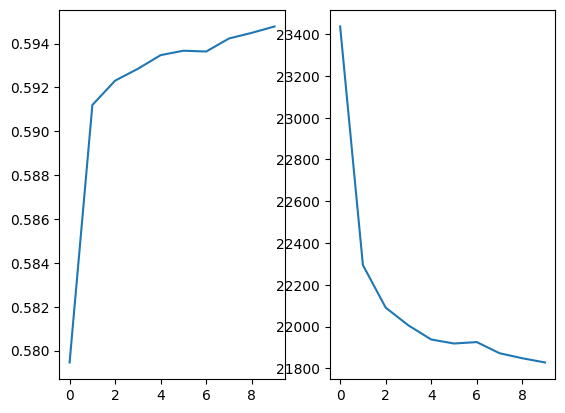

In [43]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2)
ax = ax.flatten()
ax[0].plot(range(len(history)), [h['accuracy'] for h in history])
ax[1].plot(range(len(history)), [h['loss'] for h in history])

In [44]:
# Evaluate
history_test = []
total_steps = test_ds.cardinality().numpy()

for batch in tqdm(test_ds.as_numpy_iterator(), total=total_steps):
    # print(batch['image'].shape, batch['label'])
    _, logs = train_step(state, batch)
    logs = jax.tree_map(np.asarray, logs)
    history_test.append(logs)
# hd = {'accuracy': [], 'loss': []}
# hd['accuracy'].append(np.mean([he['accuracy'] for he in history_epoch]))    # 모든 batch에 대해 mean
# hd['loss'].append(np.sum([he['loss'] for he in history_epoch]))
# history_test.append(hd)

100%|██████████| 313/313 [00:03<00:00, 96.69it/s] 


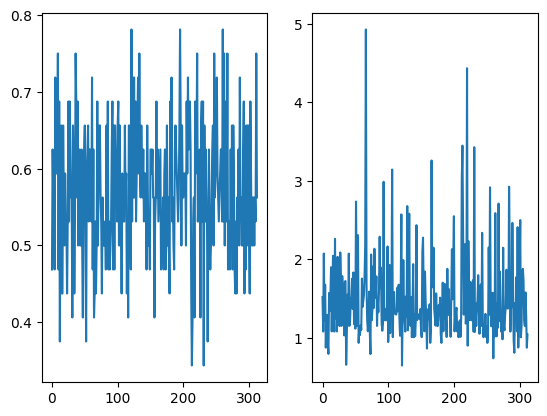

In [46]:
fig, ax = plt.subplots(1, 2)
ax = ax.flatten()
ax[0].plot(range(len(history_test)), [h['accuracy'] for h in history_test])
ax[1].plot(range(len(history_test)), [h['loss'] for h in history_test])